In [1096]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt


#Algorithms tested
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Others
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV


In [1097]:
#####################################################################################################
# Análise dos dados
#####################################################################################################

In [1098]:
#Dados puros
datasetPure = pd.read_csv('train.csv')
testsetPure = pd.read_csv('test.csv')

dataset = datasetPure.drop(['Name', 'Ticket', 'Cabin'],axis=1)
testset = testsetPure.drop(['Name', 'Ticket', 'Cabin'],axis=1)

In [1099]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [1100]:
#Age e Embarked faltando: caso Age gritante!
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [1101]:
testset.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [1102]:
#Age e Fare faltantes: caso Age gritante!
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


In [1103]:
corr_matrix = dataset.corr()
corr_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A82F59A088>,
      dtype=object)

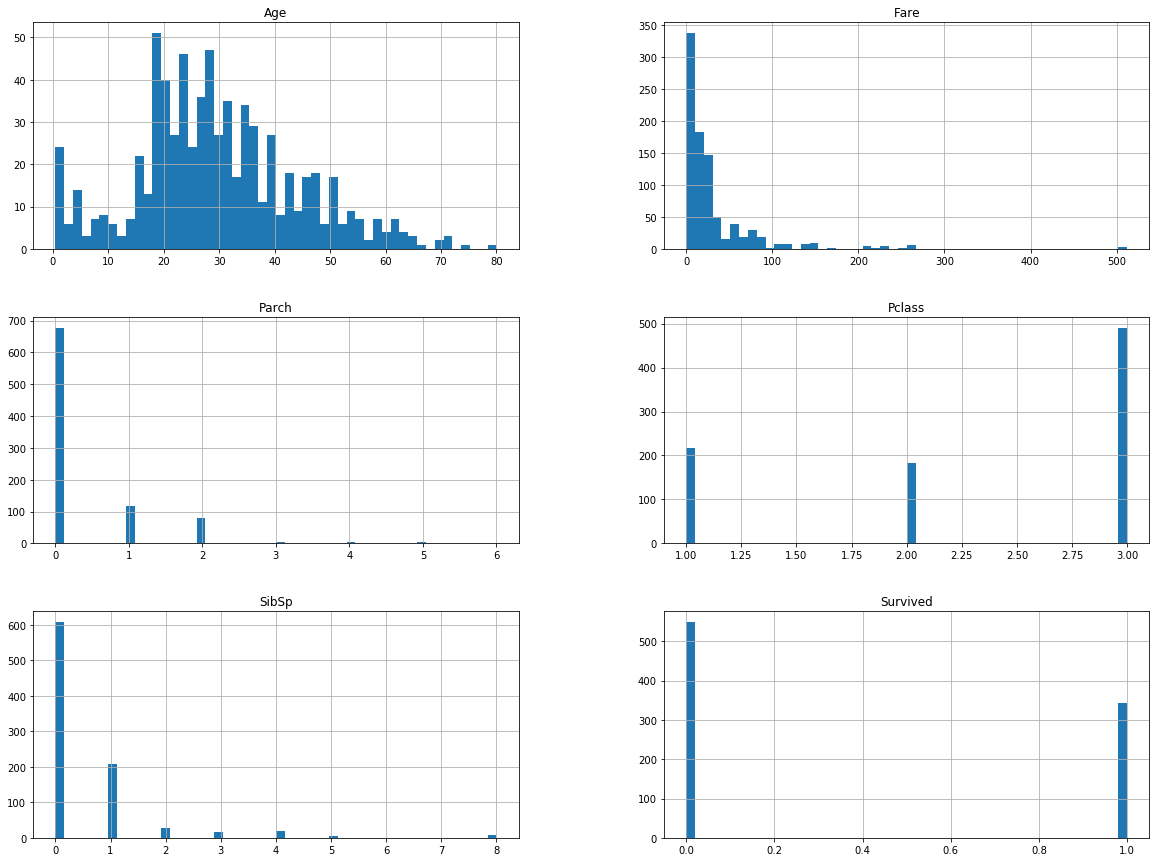

In [1104]:
#Perfil geral dos tripulantes
dataset.drop('PassengerId',axis=1).hist(figsize=(20,15), bins=50)


In [1105]:
datasetLabels = dataset.columns
datasetLabels = datasetLabels[2:]
datasetLabels

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

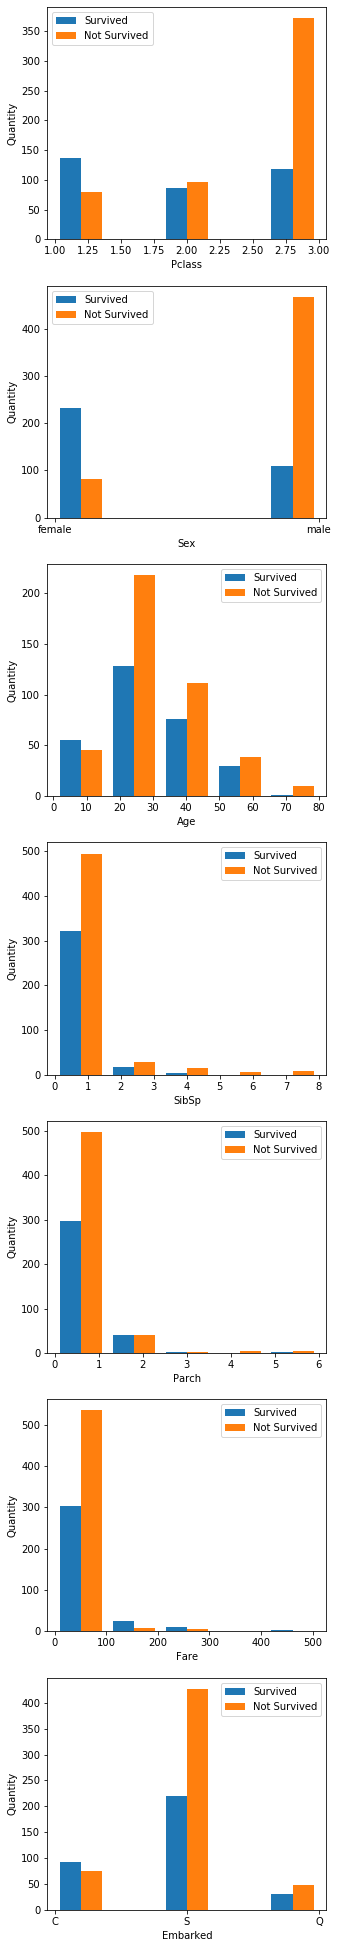

In [1106]:
labelNames = ['Survived', 'Not Survived']
fig, ax = plt.subplots(7, 1, figsize=(5,35))

for i in range(0,7):
    x1 = dataset[dataset['Survived'] == 1][datasetLabels[i]].to_numpy()
    x2 = dataset[dataset['Survived'] == 0][datasetLabels[i]].to_numpy()  
    if(datasetLabels[i] == 'Embarked'):
        x1[27] = 'S'
        x1[318] = 'S'
 
    ax[i].hist([x1,x2],bins=5,label=labelNames)
    ax[i].set_xlabel(datasetLabels[i])
    ax[i].set_ylabel('Quantity')
    ax[i].legend()
    
#x[12][27] = 'S'    #Por moda: categoria mais frequente
#x[12][318] = 'S'


In [1107]:
'''
Algumas observações

->Mais mulheres sobreviveram do que homens: Sexo é uma feature importante!

->A população do navio tinha idades entre 20 e 30 anos como categoria mais frequente
->Apesar disso, muitas crianças sobreviveram, em comparação à proporção entre vivos e não vivos para idades maiores


 Dissões em foruns, para testar posteriormente:
    ->O título (Mr. Mrs., Miss, etc) poderia ter algo a ver com classe economica e com sobrevivencia?
    ->O nome da cabine é importante? Algumas localizações de cabine ao longo do titanic foram privilegiadas em relação a outras?
    ->A idade influencia? Gente mais nova sobreviveu mais?
    ->Quais variáveis podem estar correlacionadas entre si? Resolve juntá-las e daí eliminar as originais?
    ->Ascendência da pessoa (de acordo com sobrenome) poderia ajudar?
    ->Tamanho do nome da pessoa poderia ajudar? Já que mulheres podem ter o sobrenome do marido e de sua família.
'''

'\nAlgumas observações\n\n->Mais mulheres sobreviveram do que homens: Sexo é uma feature importante!\n\n->A população do navio tinha idades entre 20 e 30 anos como categoria mais frequente\n->Apesar disso, muitas crianças sobreviveram, em comparação à proporção entre vivos e não vivos para idades maiores\n\n\n Dissões em foruns, para testar posteriormente:\n    ->O título (Mr. Mrs., Miss, etc) poderia ter algo a ver com classe economica e com sobrevivencia?\n    ->O nome da cabine é importante? Algumas localizações de cabine ao longo do titanic foram privilegiadas em relação a outras?\n    ->A idade influencia? Gente mais nova sobreviveu mais?\n    ->Quais variáveis podem estar correlacionadas entre si? Resolve juntá-las e daí eliminar as originais?\n    ->Ascendência da pessoa (de acordo com sobrenome) poderia ajudar?\n    ->Tamanho do nome da pessoa poderia ajudar? Já que mulheres podem ter o sobrenome do marido e de sua família.\n'

In [1108]:
##################################################################################################
#Processamento de dados
##################################################################################################

In [1109]:
#Dados com atributos categóricos codificados em OneHot
dataOneHot = pd.get_dummies(dataset, columns=['Embarked', 'Sex'])
testOneHot = pd.get_dummies(testset, columns=['Embarked', 'Sex'])

In [1110]:
#Dataframe -> np Array
npData = dataOneHot.to_numpy()
npTest = testOneHot.to_numpy()

#Buscando 'Fare' median, para cobrir valor faltante no test set
imputer1 = SimpleImputer(strategy='median')
imputer1.fit(dataOneHot)

x = imputer1.statistics_[6]

#Resolvendo valor 'Fare' vazio
npTest[np.isnan(npTest[:,5])] = x

In [1111]:
#Indexes of empty ages
notAgedRows = (np.isnan(npData[:,3]))
agedRows = (notAgedRows == False)

notTestRows = (np.isnan(npTest[:,2]))
agedTestRows = (notTestRows == False)

In [1112]:
#DecisionTreeREGRESSOR: fit para completar Nan's para as idades vazias
agePredictor = RandomForestRegressor(n_estimators=100)
a = np.delete(npData, [0,1,3], axis=1)[agedRows]
b = npData[agedRows,3]
agePredictor.fit(a, b)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [1113]:
#DecisionTreeRegressor: predict para completar Nan's
c = np.delete(npData, [0,1,3], axis=1)[notAgedRows]
d = np.delete(npTest, [0,2], axis=1)[notTestRows]

ageDataPred = agePredictor.predict(c)
testDataPred = agePredictor.predict(d)

ageDataFixed = npData.copy()
ageDataFixed[notAgedRows,3] = ageDataPred

testDataFixed = npTest.copy()
testDataFixed[notTestRows,2] = testDataPred

In [1114]:
#Retornando colunas "Age" agora completas
dataDF = pd.DataFrame(ageDataFixed, columns=dataOneHot.columns)
testDF = pd.DataFrame(testDataFixed, columns=testOneHot.columns)

In [1115]:
###################################################################################################
#Algoritmos
###################################################################################################

In [1140]:
def saveCSV(y_final, fileName):
    labels = np.array(['PassengerId', 'Survived'])
    y_final = y_final.astype(np.int32)
    y_pDFinal = pd.DataFrame(y_final, columns=labels)
    y_pDFinal.to_csv(fileName, index=False,sep=',')

In [1120]:
#Arvore de classificação: Survived or not?
RFClassf = RandomForestClassifier(n_estimators=100, criterion='gini')
RFClassf.fit(dataDF.iloc[:,2:],dataDF.iloc[:,1])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1134]:
#Grid Search
'''
param_grid = [{'n_estimators' : [10,50,100,500,1000, 10000], 'criterion' : ['gini', 'entropy']}]
ChooseBest = GridSearchCV(RFClassf, param_grid,cv=5,scoring='accuracy')
ChooseBest.fit(dataDF.iloc[:,2:], dataDF.iloc[:,1])
ChooseBest.best_params_
'''

In [1121]:
y_pred=cross_val_score(RFClassf, dataDF.iloc[:,2:], dataDF.iloc[:,1], cv=5, n_jobs=-1, scoring="accuracy")

In [1122]:
y_pred.mean()

0.8137153976523758

In [1124]:
x = testDF.to_numpy()
x = x.astype(int)
finalPrediction = RFClassf.predict(x[:,1:])

In [1141]:
y_final = np.hstack((testset['PassengerId'].to_numpy().reshape(-1,1).astype(np.int32), finalPrediction.reshape(-1,1)))
saveCSV(y_final,'RandomForestResults.csv')

In [824]:
######################################################################################################
#KNN
######################################################################################################

In [1138]:
#KNN->Piorou em relação à árvore. Exigiria um feature scaling melhor 
KNN = KNeighborsClassifier(n_neighbors=100, weights='distance', algorithm='auto')
KNN.fit(dataDF.iloc[:,2:], dataDF.iloc[:,1])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='distance')

In [1137]:
#Grid Search

param_grid = [{'n_neighbors' : [1,10,50,100,500], 'weights' : ['uniform', 'distance'], 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}]
ChooseBest = GridSearchCV(KNN, param_grid,cv=5,scoring='accuracy')
ChooseBest.fit(dataDF.iloc[:,2:], dataDF.iloc[:,1])
ChooseBest.best_params_

{'algorithm': 'auto', 'n_neighbors': 100, 'weights': 'distance'}

In [1139]:
y_pred=cross_val_score(KNN, dataDF.iloc[:,2:], dataDF.iloc[:,1], cv=5, n_jobs=-1, scoring="accuracy")
y_pred.mean()

0.7228799196535057

In [1143]:
x = testDF.to_numpy()
x = x.astype(int)
finalPrediction = KNN.predict(x[:,1:])

In [1144]:
y_final = np.hstack((testset['PassengerId'].to_numpy().reshape(-1,1).astype(np.int32), finalPrediction.reshape(-1,1)))
saveCSV(y_final, 'knnResults.csv')

In [ ]:
######################################################################################################
#SVC
######################################################################################################

In [1149]:
SVClass = SVC(C=1000, gamma='scale', kernel='rbf')
SVClass.fit(dataDF.iloc[:,2:], dataDF.iloc[:,1])


SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1146]:
param_grid = [{'C' : [1,10,100, 1000, 10000], 'kernel' : ['rbf', 'sigmoid'], 'gamma' : ['scale', 'auto']},
              {'kernel' : ['sigmoid'], 'coef0' : [0.001, 0.01, 0.1, 0, 1, 10, 100], 'gamma' : ['scale', 'auto'], 'C' : [10,100, 1000, 10000]}
             ]
ChooseBest = GridSearchCV(SVClass, param_grid,cv=5,scoring='accuracy')
ChooseBest.fit(dataDF.iloc[:,2:], dataDF.iloc[:,1])
ChooseBest.best_params_

{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}

In [1147]:
y_pred=cross_val_score(SVClass, dataDF.iloc[:,2:], dataDF.iloc[:,1], cv=5, n_jobs=-1, scoring="accuracy")
y_pred.mean()

0.8069487163392128

In [1150]:
x = testDF.to_numpy()
x = x.astype(int)
finalPrediction = SVClass.predict(x[:,1:])

In [1151]:
y_final = np.hstack((testset['PassengerId'].to_numpy().reshape(-1,1).astype(np.int32), finalPrediction.reshape(-1,1)))

saveCSV(y_final,'SVCResults.csv')

In [ ]:
####################################################################################################
#Resultados finais: Kaggle
# KNN: 0.64114
# RandomForest: 0.78468
# SVC: 0.78468